In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Set matplotlib parameters for consistent styling
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [3]:
def get_TPR(beta, MAF, SR_WT = 0.53, N_rep = 1000, N_Ps = 114863):
    """
    Calculate the true positive rate (TPR) for the genetic effect on the sex ratio.
    
    Parameters:
        beta (float): Effect size of the minor allele on sex ratio.
        MAF (float): Minor allele frequency.
        SR_WT (float): Baseline sex ratio in wild type.
        N_rep (int): Number of replications for the simulation.
        N_Ps (int): Number of participants.
        
    Returns:
        TPR (float): True positive rate.
    """
    # Calculate sex ratios based on the effect size
    SR_1M = SR_WT + beta
    SR_2M = SR_WT + 2*beta
    
    # Calculate the number of participants with different genotypes
    N_Ps_1M = int(N_Ps * 2*(1-MAF)*MAF)
    N_Ps_2M = int(N_Ps * MAF**2)
    N_Ps_WT = N_Ps - N_Ps_1M - N_Ps_2M 
    
    # Here we only consider the genetic effect of one side of parents (either paternal or maternal).
    #If the participant is WT
    N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M= \
        nrand.multinomial(N_Ps_WT,[1-MAF, MAF])

    # If the participant is 1M
    N_Ps_1M_Parent_WT, N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M = \
        nrand.multinomial(N_Ps_1M ,[0.5*(1-MAF), 0.5, 0.5*MAF])  

    #If the participant is WT
    N_Ps_2M_Parent_1M, N_Ps_2M_Parent_2M= \
        nrand.multinomial(N_Ps_2M,[1-MAF, MAF])
    
    # Perform simulation for N_rep repetitions
    P_list = []
    for i in range(N_rep):
        # Sample the sex of the participant
        N_Ps_WT_Male = nrand.binomial(N_Ps_WT_Parent_WT,SR_WT) + nrand.binomial(N_Ps_WT_Parent_1M,SR_1M) 
        N_Ps_WT_Female = N_Ps_WT - N_Ps_WT_Male
        
        N_Ps_1M_Male = nrand.binomial(N_Ps_1M_Parent_WT,SR_WT) + nrand.binomial(N_Ps_1M_Parent_1M,SR_1M) + \
                        nrand.binomial(N_Ps_1M_Parent_2M,SR_2M)
        N_Ps_1M_Female = N_Ps_1M - N_Ps_1M_Male

        N_Ps_2M_Male = nrand.binomial(N_Ps_2M_Parent_1M,SR_1M) + nrand.binomial(N_Ps_2M_Parent_2M,SR_2M) 
        N_Ps_2M_Female = N_Ps_2M - N_Ps_2M_Male
        
        # Perform chi-squared test
        res = stats.chi2_contingency(
            [[N_Ps_WT_Male*2 + N_Ps_1M_Male, N_Ps_2M_Male*2 + N_Ps_1M_Male],
             [N_Ps_WT_Female*2 + N_Ps_1M_Female, N_Ps_2M_Female*2 + N_Ps_1M_Female]]
        )
        
        P_list.append(res.pvalue)
    
    # Calculate true positive rate
    TPR = (np.array(P_list)<5e-8).sum()/len(P_list)
    return TPR

In [ ]:
# Parameters for simulation, 114,863 participants.
SR_WT = 0.52
beta_list = np.linspace(start=0.005,stop=0.2,num=40)
MAF_list = np.linspace(start=0.0025,stop=0.1,num=40)

# Initialize result array for TPR values
TPR_res_array = np.zeros(shape=[len(beta_list),len(MAF_list)])

# Run the simulation for each combination of beta and MAF
for i,beta in enumerate(beta_list):
    print(f'beta: {beta}')
    for j,MAF in enumerate(MAF_list):
        print(f'MAF: {MAF}',flush=True,end='\r')
        TPR_res_array[i,j] = get_TPR(beta, MAF, SR_WT = 0.52, N_rep = 1000, N_Ps = 114863)

In [ ]:
# Save the results
with open('TPR_res_array_Boraska.pkl','wb') as f:
    pickle.dump(TPR_res_array,f)

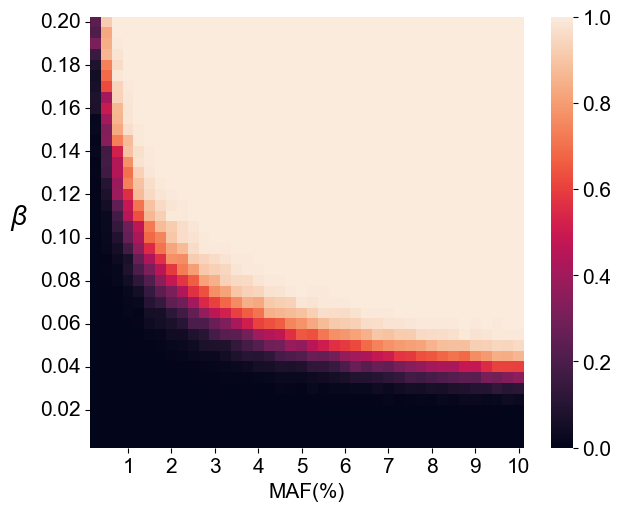

In [6]:
# Plot the results
fig,ax = plt.subplots(figsize=[7,5.6])
ax2 = sns.heatmap(TPR_res_array,)
ax.set_xticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{MAF*100:.0f}' for MAF in np.linspace(start=0.01,stop=0.1,num=10)],rotation=0,fontsize=15)
ax.set_yticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{beta:.2f}' for beta in np.linspace(start=0.02,stop=0.2,num=10)],rotation=0,fontsize=15)
ax.invert_yaxis()

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('MAF(%)',fontsize=15)
ax.set_ylabel('$\mathit{β}$',fontsize=20,rotation=0,labelpad=15)

plt.savefig('Boraska_power_analysis.pdf')